In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
# from hyperopt import tpe, fmin, Trials, hp, STATUS_OK
# from hyperopt.pyll import scope
import matplotlib.pyplot as plt
import cloudpickle as pkl

import yaml
from pathlib import Path

## Import train and test set

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
target = config['target']
as_of_end_dt = pd.to_datetime(config['date'])
n_jobs = config['n_jobs']

In [3]:
date_today = pd.to_datetime('today').date().strftime('%Y%m%d')
date_today

'20241204'

In [4]:
Path.cwd()

PosixPath('/home/jupyter/Propensity')

In [5]:
ctr = 1
model_name = f'{target}_xgb_{date_today}_v{ctr}'
while Path(f'{target}/{model_name}').exists():
    ctr += 1
    model_name = f'{target}_xgb_{date_today}_v{ctr}'

print(f"Trained model will be stored in the folder {model_name}")

train_data = pd.read_csv(f'{target}/train_data_{target}.csv', low_memory=False)
test_data = pd.read_csv(f'{target}/test_data_{target}.csv', low_memory=False)

x_train = train_data.drop('target', axis=1)
y_train = train_data['target']
x_test = test_data.drop('target', axis=1)
y_test = test_data['target']

x_train.shape

Trained model will be stored in the folder personal_loan_xgb_20241204_v1


(2154079, 14)

## Model Training

In [6]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'n_jobs': n_jobs,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'gamma': 2,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'lambda': 0.1,
    # 'alpha': 0.1
    'eval_metric': 'logloss'
    # 'scale_pos_weight': 666
}

In [7]:
%%time
model = XGBClassifier(**params)
model.fit(x_train, y_train)

CPU times: user 1min 55s, sys: 66.9 ms, total: 1min 55s
Wall time: 19.9 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.1,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=6, num_parallel_tree=None, ...)

### Store model and features list

In [8]:
Path(f'{target}/{model_name}').mkdir(exist_ok=True)
with open(f'{target}/{model_name}/model.pkl', 'wb') as f:
    pkl.dump(model, f)
    
pd.DataFrame(x_test.columns).to_csv(f'{target}/{model_name}/features.csv', index=False)

## Basic Evaluation

1. Train & Test Gini
2. Decile
3. Feature Importances Plot

In [9]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_auc_scores = []
for train_index, test_index in sss.split(x_train, y_train):
    x_val, y_val = x_train.iloc[train_index], y_train.iloc[train_index]
    y_pred_proba = model.predict_proba(x_val)
    train_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))
    
train_auc = np.mean(train_auc_scores)
print(f"""
Train Gini:
    Fold 1: {2 * train_auc_scores[0] - 1:.2f}
    Fold 2: {2 * train_auc_scores[1] - 1:.2f}
    Fold 3: {2 * train_auc_scores[2] - 1:.2f}
    Fold 4: {2 * train_auc_scores[3] - 1:.2f}
    Fold 5: {2 * train_auc_scores[4] - 1:.2f}
    
Average Gini = {2 * train_auc - 1:.2f}
""")


Train Gini:
    Fold 1: 0.59
    Fold 2: 0.59
    Fold 3: 0.59
    Fold 4: 0.59
    Fold 5: 0.59
    
Average Gini = 0.59



In [10]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
test_auc_scores = []
for train_index, test_index in sss.split(x_test, y_test):
    x_val, y_val = x_test.iloc[train_index], y_test.iloc[train_index]
    y_pred_proba = model.predict_proba(x_val)
    test_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))

test_auc = np.mean(test_auc_scores)
print(f"""
Test Gini:
    Fold 1: {2 * test_auc_scores[0] - 1:.2f}
    Fold 2: {2 * test_auc_scores[1] - 1:.2f}
    Fold 3: {2 * test_auc_scores[2] - 1:.2f}
    Fold 4: {2 * test_auc_scores[3] - 1:.2f}
    Fold 5: {2 * test_auc_scores[4] - 1:.2f}

Average Gini = {2 * test_auc - 1:.2f}
""")


Test Gini:
    Fold 1: 0.59
    Fold 2: 0.59
    Fold 3: 0.59
    Fold 4: 0.59
    Fold 5: 0.58

Average Gini = 0.59



In [18]:
y_pred_proba = model.predict_proba(x_test)[:, 1]
deciles = pd.qcut(pd.Series(y_pred_proba).rank(method='first'), q=10, labels=False, duplicates='raise') + 1
deciles_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'Actual': y_test,
    'Decile': deciles,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df = deciles_df.groupby('Decile').agg({
    'Probability': ['mean', 'nunique'],
    'Actual':'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)

agg_deciles_df['response_rate'] = agg_deciles_df['Actual'] / agg_deciles_df['Bin Size']
agg_deciles_df['decile_recall'] = agg_deciles_df['Actual'] / y_test.sum()
agg_deciles_df['capture_rate'] = agg_deciles_df['Actual'].cumsum() * 100 / y_test.sum()
agg_deciles_df['Bin Size'] = agg_deciles_df.pop('Bin Size')
agg_deciles_df

Decile Probability         Actual response_rate decile_recall capture_rate  \
                mean nunique    sum                                            
9     10    0.027378   10812   1885      0.035003      0.403381    40.338113   
8      9    0.016390    4806    846      0.015710      0.181040    58.442114   
7      8    0.012953    8881    706      0.013110      0.151081    73.550182   
6      7    0.010375    6409    425      0.007892      0.090948    82.644982   
5      6    0.008053    9005    317      0.005887      0.067837    89.428633   
4      5    0.005971    6693    226      0.004197      0.048363    94.264926   
3      4    0.004943    3260    139      0.002581      0.029745    97.239461   
2      3    0.004156    4189    102      0.001894      0.021828    99.422213   
1      2    0.002607    2510     27      0.000501      0.005778   100.000000   
0      1    0.001433     989      0      0.000000      0.000000   100.000000   

  Bin Size  
            
9    53852  
8    53852  
7    53852  
6    53852  
5    53852  
4    53852  
3    53852  
2    53852  
1    53852  
0    53852

In [19]:
y_pred_proba_train = model.predict_proba(x_train)[:, 1]
deciles_train = pd.qcut(pd.Series(y_pred_proba_train).rank(method='first'), q=10, labels=False) + 1
deciles_df_train = pd.DataFrame({
    'Probability': y_pred_proba_train,
    'Actual': y_train,
    'Decile': deciles_train,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df_train = deciles_df_train.groupby('Decile').agg({
    'Probability': ['mean', 'nunique'],
    'Actual':'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)

agg_deciles_df_train['response_rate'] = agg_deciles_df_train['Actual'] / agg_deciles_df_train['Bin Size']
agg_deciles_df_train['decile_recall'] = agg_deciles_df_train['Actual'] / y_train.sum()
agg_deciles_df_train['capture_rate'] = agg_deciles_df_train['Actual'].cumsum() * 100 / y_train.sum()
agg_deciles_df_train['Bin Size'] = agg_deciles_df_train.pop('Bin Size')
agg_deciles_df_train

Decile Probability         Actual response_rate decile_recall capture_rate  \
                mean nunique    sum                                            
9     10    0.027441   25328   7439      0.034534      0.397978    39.797774   
8      9    0.016398   10156   3591      0.016671      0.192114    59.009202   
7      8    0.012980   19644   2759      0.012808      0.147603    73.769527   
6      7    0.010397   13064   1671      0.007757      0.089397    82.709180   
5      6    0.008074   19495   1344      0.006239      0.071902    89.899422   
4      5    0.005979   13908    852      0.003955      0.045581    94.457522   
3      4    0.004948    6405    516      0.002395      0.027605    97.218061   
2      3    0.004154    8147    413      0.001917      0.022095    99.427563   
1      2    0.002600    4921    106      0.000492      0.005671    99.994650   
0      1    0.001433    1452      1      0.000005      0.000053   100.000000   

  Bin Size  
            
9   215408  
8   215408  
7   215408  
6   215408  
5   215407  
4   215408  
3   215408  
2   215408  
1   215408  
0   215408

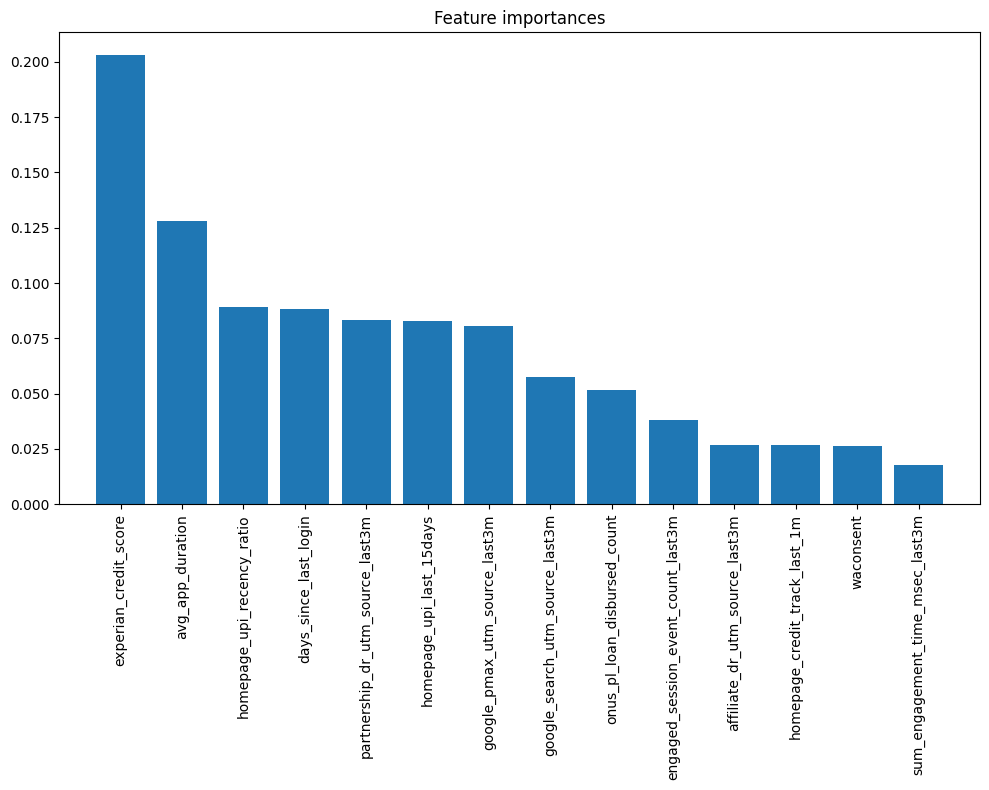

In [20]:
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [21]:
np.unique(model.predict_proba(x_train)[:, 1]).shape[0]

122511

In [22]:
np.unique(model.predict_proba(x_test)[:, 1]).shape[0]

57547

In [23]:
f"{np.mean(model.predict_proba(x_train)[:, 1])}"

'0.009440414607524872'

In [24]:
deciles_exp, bins = pd.qcut(y_pred_proba_train, q=10, labels=False, duplicates='drop', retbins=True)
bins

array([0.00113016, 0.00166754, 0.00334585, 0.00465489, 0.00535879,
       0.0068031 , 0.00925798, 0.01112154, 0.01503401, 0.01802611,
       0.15583076])